# Random Forest from scratch


### Implementing decision trees


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
df = pd.read_csv('iris.csv')
display(df.head())
df.describe()
df_x = df[df.columns[:-1]]
df_y = df[df.columns[-1:]]

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [3]:
'''
Deliverables: 
- multiclass setting classification using Gini index loss
- allow depth of decision tre to be controlled using  user selected parameter
- implementation is positioned as part of the random forest algorithm. 
- Implements two feature subsampling methods:
    - randomly select from m < p input features for termining the best split. (for each split evaluate only the selected subset of features) 
    - sekect m = p (no subsampling), m = p/2, and m = root(p) features. 
- Stopping criterion: reaching max depth, pure leaf nodes, minimal number of samples. 
    - Comment the stopping criteria. 
'''

class DTNode:
    def __init__(self, split_feature: str, threshhold:int, left: 'DTNode', right: 'DTNode', level:int, label: str, data_idx: list[int]):
        self.split_feature = split_feature
        self.threshhold = threshhold
        self.left = left
        self.right = right
        self.label = label
        self.level = level
        self.data_idx = data_idx
    
    def is_leaf(self):
        if not self.right and not self.left:
            return True
        return False

class DecisionTree:
    def __init__(self, depth: int, sampling_method: str):
        '''
        Can set depth to 0 to indicate no bound
        Set sampling method to "m=p", "m=p/2", or "m=root(p)"
        '''
        self.depth = depth
        self.sampling_method = sampling_method

        self.root: DTNode = None
        self.x = None
        self.y = None
        self.xcols = None
        self.ycols = None
        self.q: list[DTNode] = []
    
    def npindex(self, x_idx):
        return self.x[np.isin(self.x[:, 0], x_idx)]

    def get_label(self, x_idx):
        '''
        Gets the majority class of a dataset given indices x_idx
        '''
        y = self.y[x_idx.astype(int)]
        classes, count = np.unique(y, return_counts=True)

        max_class, max_count = classes[0], count[0]
        for i in range(1, len(classes)):
            if count[i] > max_count:
                max_class = classes[i]
                max_count = count[i]
        
        return max_class
    
    def is_pure(self, x_idx):
        '''
        Returns if the tree is pure
        '''
        y = self.y[x_idx.astype(int)]
        classes, count = np.unique(y, return_counts=True)

        if len(classes) <= 1:
            return True
        return False

    def gini_index(self, classes, counts):
        '''Gini index given classes and counts'''
        total_count = sum(counts)
        loss = 0
        for i in range(len(classes)):
            prob = counts[i] / total_count
            loss += prob * (1 - prob)
        return loss


    def calc_loss(self, idx1, idx2):
        '''
        Given a split, calculates the loss for the split
        '''
        classes1, counts1 = np.unique(self.y[idx1.astype(int)], return_counts=True)
        gini1 = self.gini_index(classes1, counts1)

        classes2, counts2 = np.unique(self.y[idx2.astype(int)], return_counts=True)
        gini2 = self.gini_index(classes2, counts2)

        total_len = len(idx1) + len(idx2)
        
        return len(idx1) / total_len * gini1 + len(idx2) / total_len * gini2
    
    def sample_features(self, features):
        if self.sampling_method == "m=p":
            return np.random.choice(features, len(features), replace=True)
        elif self.sampling_method == "m=p/2":
            return np.random.choice(features, int(len(features) / 2), replace=True)
        elif self.sampling_method == "m=root(p)":
            return np.random.choice(features, int(np.sqrt(len(features))), replace=True)
        else:
            return Exception("Invalid feature selection method")

    
    def next_feature(self, x_idx):
        '''
        Determines the next feature and the splitting point for a dataset given by x_idx

        - for every feature, choose 5 random points. Get max. 
        '''

        best_feature = best_threshhold = None
        min_loss = 10 # max loss is 1
        
        # select only where idx is
        # x = self.x[x_idx]
        x = self.npindex(x_idx)

        features = self.sample_features(range(1, len(self.xcols) + 1))

        for col in features: # start 1 to ignore idx col
            feature = x[:, col]

            if feature.size == 0:
                print("whoops no feature", feature, col, x_idx, end=" ")
                continue

            quantiles = np.quantile(feature, np.arange(0.05, 0.95, 0.05))

            for q in quantiles:
                left_idx = x[np.where(x[:, col] <= q)][:, 0]
                right_idx = x[np.where(x[:, col] > q)][:, 0]

                loss = self.calc_loss(left_idx, right_idx)

                if loss < min_loss:
                    min_loss = loss
                    best_feature = col
                    best_threshhold = q
        
        return best_feature, best_threshhold
    
    
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):

        # init data 
        self.x = x.values
        self.y = y.values
        self.xcols = list(x.columns)
        self.ycols = list(y.columns)

        # augment x with indices
        idx = np.array(range(self.x.shape[0])).astype(int).reshape(-1, 1)
        self.x = np.hstack((idx, x))

        # init root
        self.root = DTNode(None, None, None, None, 0, None, range(len(self.x)))
        self.root.split_feature, self.root.threshhold = self.next_feature(self.root.data_idx)
        self.root.label = self.get_label(idx)
        self.q.append(self.root)

        # actual loop
        while self.q:
            parent = self.q.pop(0)
            parent_x = self.npindex(parent.data_idx)
            # print(parent.split_feature, parent.threshhold, parent.label)

            # stopping condition: prune at height
            if self.depth != 0 and parent.level >= self.depth:
                continue

            # restrict data
            left_idx = parent_x[np.where(parent_x[:, parent.split_feature] <= parent.threshhold)][:, 0]
            right_idx = parent_x[np.where(parent_x[:, parent.split_feature] > parent.threshhold)][:, 0]

            # stopping condition: feature split leaves none
            if left_idx.size == 0 or right_idx.size == 0:
                continue

            # construct child
            child_left = DTNode(None, None, None, None, parent.level + 1, None, left_idx)
            child_left.split_feature, child_left.threshhold = self.next_feature(child_left.data_idx)
            child_left.label = self.get_label(child_left.data_idx)

            child_right = DTNode(None, None, None, None, parent.level + 1, None, right_idx)
            child_right.split_feature, child_right.threshhold = self.next_feature(child_right.data_idx)
            child_right.label = self.get_label(child_right.data_idx)

            parent.left = child_left
            parent.right = child_right
            
            # stopping condition: is pure
            
            if not self.is_pure(child_left.data_idx):
                self.q.append(child_left)
            
            if not self.is_pure(child_right.data_idx):
                self.q.append(child_right)
    
    def predict(self, x: pd.DataFrame):
        preds = []
        x = x.values
        for i in range(len(x)):
            # yi = self.y[i]
            curnode = self.root
            while not curnode.is_leaf():
                row = x[i]
                # -1 because all feature counts were augmented
                if row[curnode.split_feature - 1] <= curnode.threshhold:
                    curnode = curnode.left
                else:
                    curnode = curnode.right
            # print(yi[0], curnode.label)
            preds.append(curnode.label)
        return preds

In [4]:
dt = DecisionTree(depth=6, sampling_method="m=p")
dt.fit(df_x, df_y)
preds = dt.predict(df_x)
actual = df_y
cm = confusion_matrix(preds, actual)
cm

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

# Comparing to SKLearn


In [7]:
from sklearn.tree import DecisionTreeClassifier
df = pd.read_csv("iris.csv")
train_df = df.groupby('variety', group_keys=False).apply(lambda x: x.sample(frac=2/3, random_state=42)).sample(frac=1)
test_df = df.drop(train_df.index)

df_x_train = train_df[train_df.columns[:-1]]
df_y_train = train_df[train_df.columns[-1:]]

df_x_test = test_df[test_df.columns[:-1]]
df_y_test = test_df[test_df.columns[-1:]]

# my model
dt = DecisionTree(0, "m=p")
dt.fit(df_x_train, df_y_train)

# sklearn model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(df_x_train, df_y_train)

# compare confusion matrices
my_preds = dt.predict(df_x_test)
mycm = confusion_matrix(my_preds, df_y_test)

sklearn_preds = clf.predict(df_x_test)
sklearn_cm = confusion_matrix(sklearn_preds, df_y_test)

display(mycm, sklearn_cm)

array([[15,  0,  0],
       [ 2, 13,  4],
       [ 0,  4, 13]], dtype=int64)

array([[17,  0,  0],
       [ 0, 15,  0],
       [ 0,  2, 17]], dtype=int64)

## Implementing Random Forest


In [8]:
df = pd.read_csv("heart.csv")
df = pd.get_dummies(df, columns=['cp', 'restecg'])

train_df = df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=2/3, random_state=42)).sample(frac=1)
test_df = df.drop(train_df.index)

xcols = [i for i in train_df.columns if i != 'target']
ycol = ['target']

df_x_train = train_df[xcols]
df_y_train = train_df[ycol]

df_x_test = test_df[xcols]
df_y_test = test_df[ycol]

In [ ]:
class RandomForest:
    def __init__(self, num_trees, sampling_method, max_depth):
        self.num_trees = num_trees
        self.sampling_method = sampling_method
        self.max_depth = max_depth

        self.trees: list[DecisionTree] = []
    
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):
        for _ in range(self.num_trees):
            dt = DecisionTree(depth=self.max_depth, sampling_method=self.sampling_method)
            dt.fit(x, y)
            self.trees.append(dt)
        
    def predict(self, x: pd.DataFrame):
        preds = []
        for tree in self.trees:
            preds.append(tree.predict(x))
        
        preds_df = pd.DataFrame(preds)
        res = preds_df.mode(axis=0)
        return res.iloc[0]

rf = RandomForest(2, 'm=root(p)', 5)

In [15]:
trees = [1,2,5,10,20,50,100,200,500,1000]
sampling_methods = ['m=p', 'm=p/2', 'm=root(p)']

results = []

for sampling_method in sampling_methods:
    for num_tree in trees:
        rf = RandomForest(num_tree, sampling_method, 5)
        rf.fit(df_x_train, df_y_train)
        res = rf.predict(df_x_test)
        print(f"Sampling method: {sampling_method}, num_tree: {num_tree}")

        # get error
        count = 0
        for i in range(len(res)):
            if res[i] != df_y_test['target'].iloc[i]:
                count += 1

        results.append({"sampling_method": sampling_method, "trees": num_tree, "test_classification_error": count / len(res)})

Sampling method: m=p, num_tree: 1
Sampling method: m=p, num_tree: 2
Sampling method: m=p, num_tree: 5
Sampling method: m=p, num_tree: 10
Sampling method: m=p, num_tree: 20
Sampling method: m=p, num_tree: 50
Sampling method: m=p, num_tree: 100
Sampling method: m=p, num_tree: 200
Sampling method: m=p, num_tree: 500
Sampling method: m=p, num_tree: 1000
Sampling method: m=p/2, num_tree: 1
Sampling method: m=p/2, num_tree: 2
Sampling method: m=p/2, num_tree: 5
Sampling method: m=p/2, num_tree: 10
Sampling method: m=p/2, num_tree: 20
Sampling method: m=p/2, num_tree: 50
Sampling method: m=p/2, num_tree: 100
Sampling method: m=p/2, num_tree: 200
Sampling method: m=p/2, num_tree: 500
Sampling method: m=p/2, num_tree: 1000
Sampling method: m=root(p), num_tree: 1
Sampling method: m=root(p), num_tree: 2
Sampling method: m=root(p), num_tree: 5
Sampling method: m=root(p), num_tree: 10
Sampling method: m=root(p), num_tree: 20
Sampling method: m=root(p), num_tree: 50
Sampling method: m=root(p), num_t

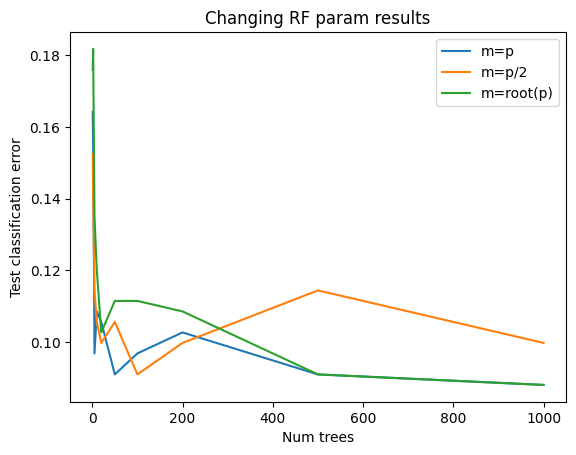

In [25]:
res_df = pd.DataFrame(results)

for sampling_method in sampling_methods: 
    temp = res_df.loc[res_df['sampling_method'] == sampling_method]
    plt.plot(temp['trees'],temp['test_classification_error'], label=sampling_method)

plt.xlabel("Num trees")
plt.ylabel("Test classification error")
plt.title("Changing RF param results")
plt.legend()
plt.show()